In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Activation, Dense, Flatten, Dropout, BatchNormalization, Conv2D, MaxPool2D, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
import itertools
import os
import shutil
import random
import matplotlib.pyplot as plt

2024-07-05 05:26:52.798668: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-05 05:26:52.798780: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-05 05:26:52.930550: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print("Num GPUs Available: ", len(physical_devices))
if physical_devices:
    for gpu in physical_devices:
        tf.config.experimental.set_memory_growth(gpu, True)

Num GPUs Available:  1


In [3]:
# This function prints and plots the confusion matrix.
# Normalization can be applied by setting `normalize=True`.
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    # print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


In [4]:
# plot images
def plotImages(images):
    fig, axes = plt.subplots(1, 10, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

In [5]:
# plot images
def plotImages(images):
    fig, axes = plt.subplots(1, 10, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

In [6]:
def plot_hist(hist):
    plt.plot(hist.history["accuracy"], label="train_acc")
    plt.plot(hist.history["val_accuracy"], label="val_acc")
    plt.plot(hist.history["loss"], label="train_loss")
    plt.plot(hist.history["val_loss"], label="val_loss")
    plt.title("Training Loss And Accuracy")
    plt.ylabel("Loss/Accuracy")
    plt.xlabel("epoch")
    plt.legend(loc="upper left")
    plt.show()

In [7]:
# Processing The Image Datasets
classes = ['BEAR','BISON','CHEETAH','ELEPHANT','FOX','GAZELLE','GIRAFFE','GORILLA','HIPPO','HORRSE','HYENA','KOALA','LEOPARD','LION','MEERKAT','PIG','PORCUPINE','RHINO','TIGER','WOLF','ZEBRA']
train_path = '/kaggle/input/zoo-2000/Wild_Animals/Train'
valid_path = '/kaggle/input/zoo-2000/Wild_Animals/Validation'
test_path = '/kaggle/input/zoo-2000/Wild_Animals/Test'

train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.resnet50.preprocess_input) \
    .flow_from_directory(directory=train_path, target_size=(224,224), classes=classes, batch_size=32)
valid_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.resnet50.preprocess_input) \
    .flow_from_directory(directory=valid_path, target_size=(224,224), classes=classes, batch_size=32)
test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.resnet50.preprocess_input) \
    .flow_from_directory(directory=test_path, target_size=(224,224), classes=classes, batch_size=10, shuffle=False)

Found 23691 images belonging to 21 classes.
Found 4051 images belonging to 21 classes.
Found 11802 images belonging to 21 classes.


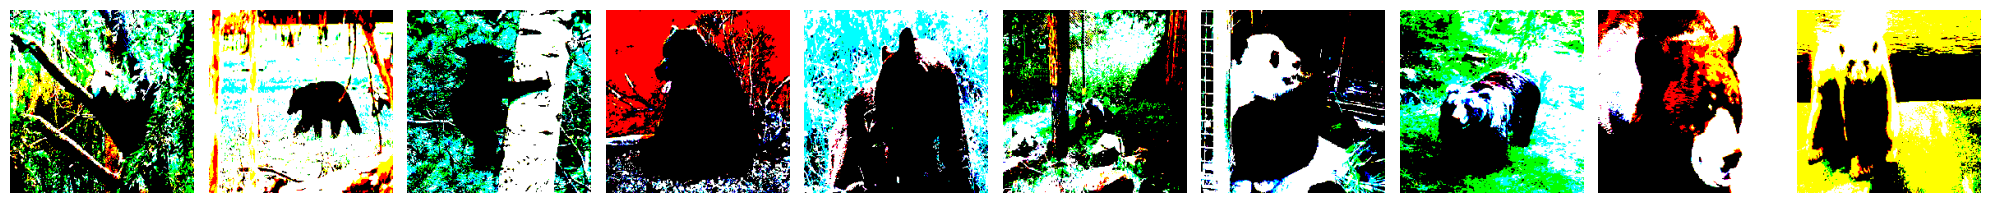

In [8]:
imgs, label = next(test_batches)
plotImages(imgs)

In [9]:
base_model = tf.keras.applications.ResNet101(weights='imagenet')
# base_model.trainable = False
base_model.summary()

179648224/179648224 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "resnet101"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 44,707,176 (170.54 MB)

 Trainable params: 44,601,832 (170.14 MB)

 Non-trainable params: 105,344 (411.50 KB)

In [10]:
x = base_model.layers[-3].output
x = GlobalAveragePooling2D()(x)
# x = Dense(units=256, activation='relu')(x)
# x = Dropout(0.5)(x)
x = Dense(units=256, activation='relu')(x)
x = Dropout(0.6)(x)
output = Dense(units=21, activation='softmax')(x)
model = Model(inputs = base_model.input, outputs = output)

In [11]:
for layer in model.layers[:-20]:
    layer.trainable = False

In [12]:
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath='/kaggle/working/Categorical_Model.weights.h5',
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=0)

In [ ]:
model.summary()

Model: "functional_1"

In [ ]:
optimizer = tf.optimizers.SGD(learning_rate=0.0001, momentum=0.9, nesterov=True, weight_decay=0.01/40)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


  1/741 ━━━━━━━━━━━━━━━━━━━━ 5:50:36 28s/step - accuracy: 0.0000e+00 - loss: 4.0826

I0000 00:00:1720157268.742286     105 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1720157268.830466     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


741/741 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step - accuracy: 0.3115 - loss: 2.5389

W0000 00:00:1720157405.433276     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


741/741 ━━━━━━━━━━━━━━━━━━━━ 192s 220ms/step - accuracy: 0.3118 - loss: 2.5379 - val_accuracy: 0.8815 - val_loss: 0.5320
Epoch 2/10
741/741 ━━━━━━━━━━━━━━━━━━━━ 81s 108ms/step - accuracy: 0.7851 - loss: 0.8125 - val_accuracy: 0.9240 - val_loss: 0.3054
Epoch 3/10
741/741 ━━━━━━━━━━━━━━━━━━━━ 80s 107ms/step - accuracy: 0.8560 - loss: 0.5292 - val_accuracy: 0.9338 - val_loss: 0.2397
Epoch 4/10
741/741 ━━━━━━━━━━━━━━━━━━━━ 80s 107ms/step - accuracy: 0.8867 - loss: 0.4088 - val_accuracy: 0.9427 - val_loss: 0.2088
Epoch 5/10
741/741 ━━━━━━━━━━━━━━━━━━━━ 80s 107ms/step - accuracy: 0.8983 - loss: 0.3582 - val_accuracy: 0.9464 - val_loss: 0.1929
Epoch 6/10
741/741 ━━━━━━━━━━━━━━━━━━━━ 80s 107ms/step - accuracy: 0.9092 - loss: 0.3225 - val_accuracy: 0.9482 - val_loss: 0.1811
Epoch 7/10
741/741 ━━━━━━━━━━━━━━━━━━━━ 79s 105ms/step - accuracy: 0.9176 - loss: 0.2900 - val_accuracy: 0.9511 - val_loss: 0.1727
Epoch 8/10
741/741 ━━━━━━━━━━━━━━━━━━━━ 80s 107ms/step - accuracy: 0.9274 - loss: 0.2570 - va

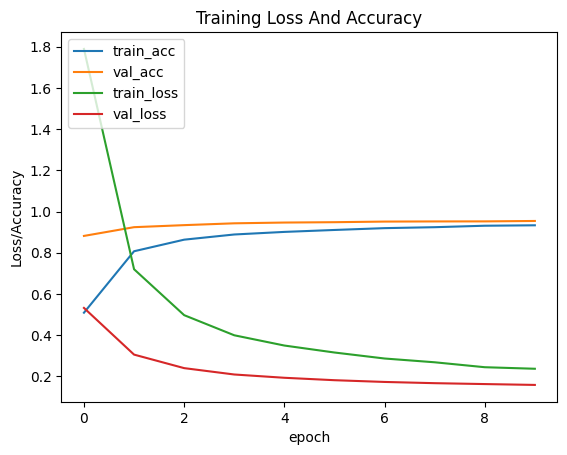

In [15]:
H = model.fit(x=train_batches, validation_data=valid_batches, epochs=10)
plot_hist(H)

In [16]:
test_labels = test_batches.classes

In [17]:
predict = model.predict(x=test_batches, verbose=0)

In [18]:
cm = confusion_matrix(y_true=test_batches.classes, y_pred=np.argmax(predict, axis=-1))

In [19]:
test_batches.class_indices

{'BEAR': 0,
 'BISON': 1,
 'CHEETAH': 2,
 'ELEPHANT': 3,
 'FOX': 4,
 'GAZELLE': 5,
 'GIRAFFE': 6,
 'GORILLA': 7,
 'HIPPO': 8,
 'HORRSE': 9,
 'HYENA': 10,
 'KOALA': 11,
 'LEOPARD': 12,
 'LION': 13,
 'MEERKAT': 14,
 'PIG': 15,
 'PORCUPINE': 16,
 'RHINO': 17,
 'TIGER': 18,
 'WOLF': 19,
 'ZEBRA': 20}

Normalized confusion matrix


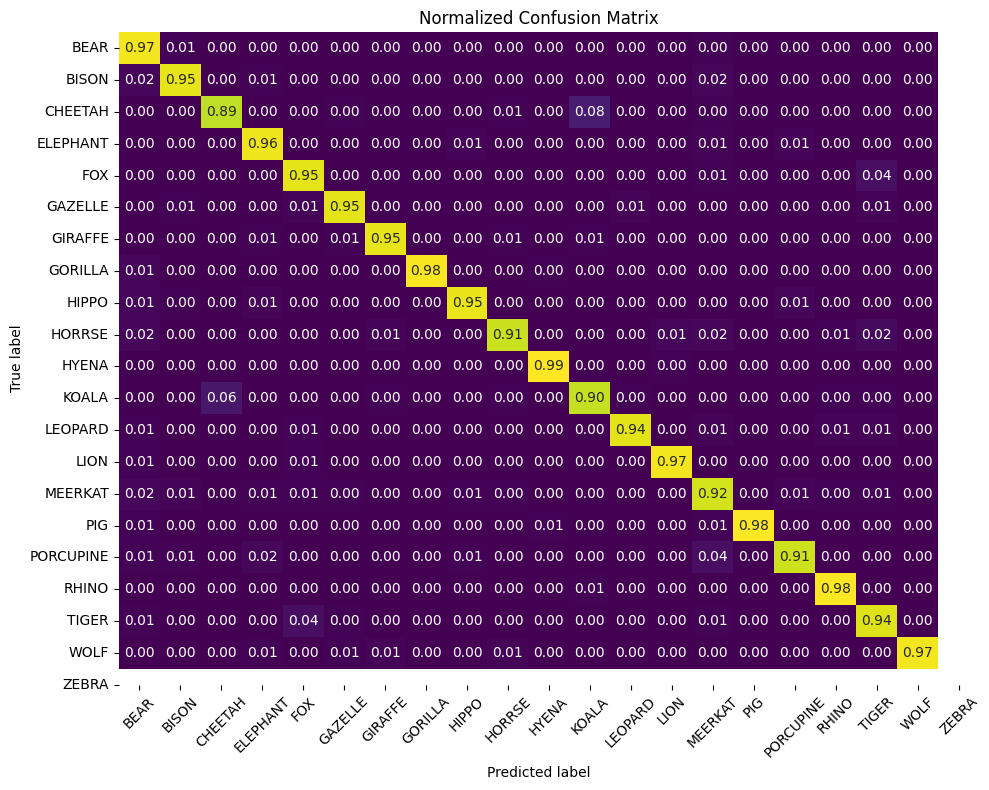

In [23]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion Matrix', cmap='viridis'):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='.2f' if normalize else 'd', cmap=cmap, 
                xticklabels=classes, yticklabels=classes, cbar=False)
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

# Example usage:
cm = confusion_matrix(y_true=test_batches.classes, y_pred=np.argmax(predict, axis=-1))
cm_plot_labels = ['BEAR','BISON','CHEETAH','ELEPHANT','FOX','GAZELLE','GIRAFFE','GORILLA','HIPPO','HORRSE','HYENA','KOALA','LEOPARD','LION','MEERKAT','PIG','PORCUPINE','RHINO','TIGER','WOLF','ZEBRA']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, normalize=True, title='Normalized Confusion Matrix')


In [21]:
model.save("Marine_Animals_ResNet101_Tuned_Model_95.h5")

In [22]:
from IPython.display import FileLink
FileLink(r'Marine_Animals_ResNet101_Tuned_Model_95.h5')

/kaggle/working/Marine_Animals_ResNet101_Tuned_Model_95.h5